In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string
import spacy
from tqdm import tqdm
import tensorflow as tf
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

2024-10-24 08:05:14.866129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 08:05:15.414586: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 08:05:15.540106: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 08:05:16.517242: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 08:05:26.147863: W tensorflow/comp

In [1]:
import pandas as pd

train_data = pd.read_csv('train_data.csv')
test_duplicate_data = pd.read_csv('test_data.csv')
valid_data = pd.read_csv('valid_data.csv')

In [2]:
test_duplicate_data

,text,label,clean_text,lemmatized_text,stemmed_text,pos,combined_text
0,You could forgive Apple's legal team for comin...,0,you could forgive apples legal team for coming...,you could forgive apple legal team for come ac...,you could forgiv appl legal team for come acro...,PRON AUX VERB NOUN ADJ NOUN ADP VERB ADP DET A...,you could forgive apples legal team for coming...
1,Liberal and conservative are two different way...,1,liberal and conservative are two different way...,liberal and conservative be two different way ...,liber and conserv are two differ way of think ...,ADJ CCONJ ADJ AUX NUM ADJ NOUN ADP VERB ADP NO...,liberal and conservative are two different way...
2,The sun is also white . It just appears yellow...,0,the sun is also white it just appears yellow next,the sun be also white it just appear yellow next,the sun is also white it just appear yellow next,DET NOUN AUX ADV ADJ PRON ADV VERB ADJ ADP,the sun is also white it just appears yellow n...
3,North Lanarkshire Council in Scotland has laun...,1,north lanarkshire council in scotland has laun...,north lanarkshire council in scotland have lau...,north lanarkshir council in scotland has launc...,PROPN PROPN PROPN ADP PROPN AUX VERB DET NOUN ...,north lanarkshire council in scotland has laun...
4,"""I was looking for something that was comparab...",0,i was looking for something that was comparabl...,I be look for something that be comparable for...,i was look for someth that was compar for my p...,PRON AUX VERB ADP PRON PRON AUX ADJ ADP PRON NOUN,i was looking for something that was comparabl...
...,...,...,...,...,...,...,...
14835,These Vienna talks for the first time include ...,0,these vienna talks for the first time include ...,these vienna talk for the first time include a...,these vienna talk for the first time includ al...,DET NOUN VERB ADP DET ADJ NOUN VERB DET DET AD...,these vienna talks for the first time include ...
14836,India's film censorship board has granted a ce...,1,indias film censorship board has granted a cer...,indias film censorship board have grant a cert...,india film censorship board has grant a certif...,PROPN PROPN NOUN NOUN AUX VERB DET NOUN ADP DE...,indias film censorship board has granted a cer...
14837,"Expanding ammunition, also known as hollow poi...",1,expanding ammunition also known as hollow poin...,expand ammunition also know as hollow point bu...,expand ammunit also known as hollow point bull...,VERB NOUN ADV VERB ADP ADJ NOUN NOUN AUX VERB ...,expanding ammunition also known as hollow poin...
14838,They will have in-depth discussions on relatio...,0,they will have indepth discussions on relation...,they will have indepth discussion on relation ...,they will have indepth discuss on relat betwee...,PRON AUX VERB ADJ NOUN ADP NOUN ADP DET NUM NO...,they will have indepth discussions on relation...


In [3]:
train_x, test_x, train_y, test_y = train_data['combined_text'], test_duplicate_data['combined_text'], train_data['label'], test_duplicate_data['label']
train_x, valid_x, train_y, valid_y = train_data['combined_text'], valid_data['combined_text'], train_data['label'], valid_data['label']

In [4]:
# TF-IDF Vectorization using all combined text features
tfidf = TfidfVectorizer(max_features=5000)
train_x_tfidf = tfidf.fit_transform(train_x).toarray()
valid_x_tfidf = tfidf.transform(valid_x).toarray()
test_x_tfidf = tfidf.transform(test_x).toarray()

# Convert labels to numpy arrays
train_y = np.array(train_y)
valid_y = np.array(valid_y)
test_y = np.array(test_y)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_x_tfidf, train_y)).batch(64).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_x_tfidf, valid_y)).batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_x_tfidf, test_y)).batch(64).prefetch(tf.data.AUTOTUNE)

2024-10-24 08:06:13.350773: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-10-24 08:06:13.380580: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5936080000 exceeds 10% of free system memory.


In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef, 
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
train_x_tfidf_reshaped = train_x_tfidf.reshape((train_x_tfidf.shape[0], train_x_tfidf.shape[1], 1))
valid_x_tfidf_reshaped = valid_x_tfidf.reshape((valid_x_tfidf.shape[0], valid_x_tfidf.shape[1], 1))
test_x_tfidf_reshaped = test_x_tfidf.reshape((test_x_tfidf.shape[0], test_x_tfidf.shape[1], 1))



--- Fold 1 ---


/home/yadagiri/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 773s 208ms/step - accuracy: 0.7542 - loss: 0.4573 - val_accuracy: 0.8338 - val_loss: 0.3225
Epoch 2/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 806s 217ms/step - accuracy: 0.8473 - loss: 0.3067 - val_accuracy: 0.8408 - val_loss: 0.3068
Epoch 3/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 792s 213ms/step - accuracy: 0.8675 - loss: 0.2662 - val_accuracy: 0.8410 - val_loss: 0.3115
Epoch 4/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 759s 204ms/step - accuracy: 0.8866 - loss: 0.2364 - val_accuracy: 0.8378 - val_loss: 0.3116
Epoch 5/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 755s 203ms/step - accuracy: 0.9004 - loss: 0.2138 - val_accuracy: 0.8372 - val_loss: 0.3347
928/928 ━━━━━━━━━━━━━━━━━━━━ 46s 49ms/step
464/464 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step


--- Fold 2 ---
Epoch 1/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 757s 204ms/step - accuracy: 0.7544 - loss: 0.4601 - val_accuracy: 0.8331 - val_loss: 0.3268
Epoch 2/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 756s 204ms/step - accuracy: 0.8480 - loss: 0.3049 - val_ac

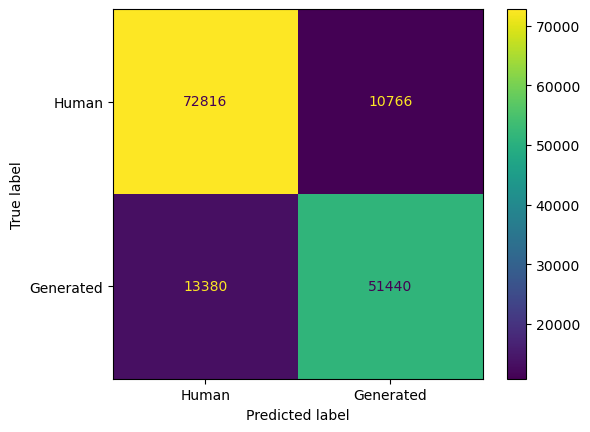

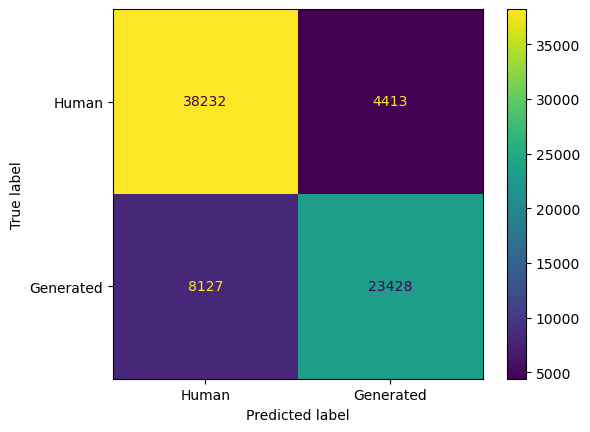

In [9]:
def build_model():
    """Build and compile the CNN model."""
    model = Sequential([
        Conv1D(128, 3, activation='relu', input_shape=(train_x_tfidf_reshaped.shape[1], 1)),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# K-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store overall predictions and true labels for validation and test sets
overall_valid_true, overall_valid_pred = [], []
overall_test_true, overall_test_pred = [], []

fold = 1

for train_index, val_index in kf.split(train_x_tfidf_reshaped):
    print(f"\n\n--- Fold {fold} ---")

    # Split data for the current fold
    X_train, X_val = train_x_tfidf_reshaped[train_index], train_x_tfidf_reshaped[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    # Build and train the model
    model_cnn_kfold = build_model()
    model_cnn_kfold.fit(X_train, y_train, validation_data=(valid_x_tfidf_reshaped, valid_y), epochs=5, verbose=1)

    # Validation predictions
    val_pred_y = (model_cnn_kfold.predict(X_val) > 0.5).astype("int32").flatten()
    overall_valid_true.extend(y_val)
    overall_valid_pred.extend(val_pred_y)

    # Test predictions
    test_pred_y = (model_cnn_kfold.predict(test_x_tfidf_reshaped) > 0.5).astype("int32").flatten()
    overall_test_true.extend(test_y)
    overall_test_pred.extend(test_pred_y)

    fold += 1

# Compute overall validation metrics
overall_valid_accuracy = accuracy_score(overall_valid_true, overall_valid_pred)
overall_valid_f1 = f1_score(overall_valid_true, overall_valid_pred)
overall_valid_mcc = matthews_corrcoef(overall_valid_true, overall_valid_pred)
overall_valid_cmd = confusion_matrix(overall_valid_true, overall_valid_pred)
overall_valid_report = classification_report(overall_valid_true, overall_valid_pred)

# Compute overall test metrics
overall_test_accuracy = accuracy_score(overall_test_true, overall_test_pred)
overall_test_f1 = f1_score(overall_test_true, overall_test_pred)
overall_test_mcc = matthews_corrcoef(overall_test_true, overall_test_pred)
overall_test_cmd = confusion_matrix(overall_test_true, overall_test_pred)
overall_test_report = classification_report(overall_test_true, overall_test_pred)

# Display overall validation metrics
print("\n\n--- Overall Validation Metrics ---")
print(f"Accuracy: {overall_valid_accuracy}")
print(f"F1 Score: {overall_valid_f1}")
print(f"MCC: {overall_valid_mcc}")
print("Confusion Matrix:\n", overall_valid_cmd)
print("Classification Report:\n", overall_valid_report)

# Display overall test metrics
print("\n\n--- Overall Test Metrics ---")
print(f"Accuracy: {overall_test_accuracy}")
print(f"F1 Score: {overall_test_f1}")
print(f"MCC: {overall_test_mcc}")
print("Confusion Matrix:\n", overall_test_cmd)
print("Classification Report:\n", overall_test_report)

# Plot confusion matrices
ConfusionMatrixDisplay(confusion_matrix=overall_valid_cmd, display_labels=['Human', 'Generated']).plot()
ConfusionMatrixDisplay(confusion_matrix=overall_test_cmd, display_labels=['Human', 'Generated']).plot()

In [10]:
model_cnn_kfold.save('model_CNN_Kfold.h5')



--- Fold 1 ---


/home/yadagiri/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7532 - loss: 0.4682 - val_accuracy: 0.8255 - val_loss: 0.3412
Epoch 2/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8365 - loss: 0.3246 - val_accuracy: 0.8368 - val_loss: 0.3259
Epoch 3/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.8599 - loss: 0.2854 - val_accuracy: 0.8377 - val_loss: 0.3239
Epoch 4/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8743 - loss: 0.2572 - val_accuracy: 0.8348 - val_loss: 0.3317
Epoch 5/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8870 - loss: 0.2337 - val_accuracy: 0.8332 - val_loss: 0.3456
928/928 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


--- Fold 2 ---
Epoch 1/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.7503 - loss: 0.4674 - val_accuracy: 0.8246 - val_loss: 0.3451
Epoch 2/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8407 - loss: 0.3204 - val_accuracy: 0.8329 - val_loss

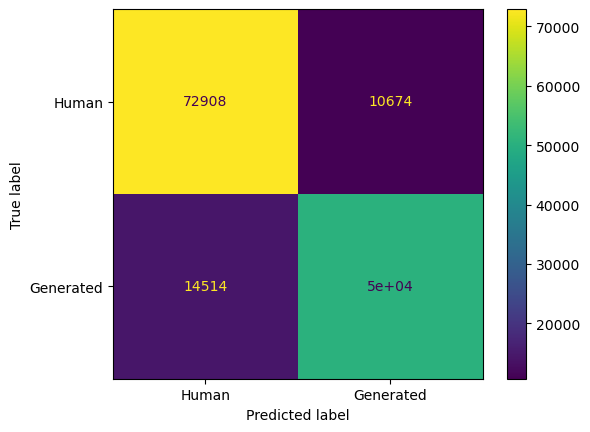

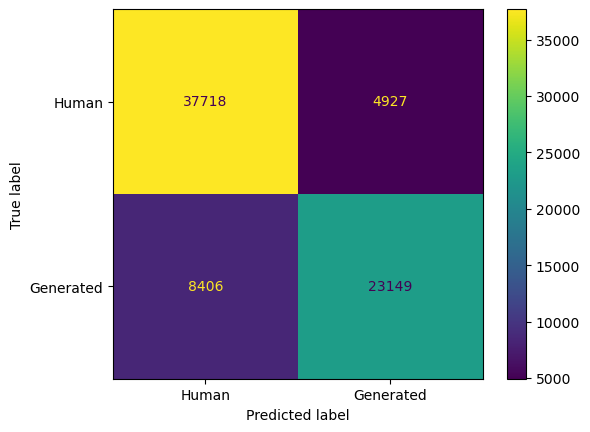

In [11]:
def build_lstm_model():
    """Build and compile the LSTM-like dense model."""
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(train_x_tfidf.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# K-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store overall predictions and true labels for validation and test sets
overall_valid_true, overall_valid_pred = [], []
overall_test_true, overall_test_pred = [], []

fold = 1

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(train_x_tfidf):
    print(f"\n\n--- Fold {fold} ---")

    # Split data for the current fold
    X_train, X_val = train_x_tfidf[train_index], train_x_tfidf[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    # Build and train the model
    model = build_lstm_model()
    model.fit(X_train, y_train, validation_data=(valid_x_tfidf, valid_y), epochs=5, verbose=1)

    # Validation predictions
    val_pred_y = (model.predict(X_val) > 0.5).astype("int32").flatten()
    overall_valid_true.extend(y_val)
    overall_valid_pred.extend(val_pred_y)

    # Test predictions
    test_pred_y = (model.predict(test_x_tfidf) > 0.5).astype("int32").flatten()
    overall_test_true.extend(test_y)
    overall_test_pred.extend(test_pred_y)

    fold += 1

# Compute overall metrics for validation
overall_valid_accuracy = accuracy_score(overall_valid_true, overall_valid_pred)
overall_valid_f1 = f1_score(overall_valid_true, overall_valid_pred)
overall_valid_mcc = matthews_corrcoef(overall_valid_true, overall_valid_pred)
overall_valid_cmd = confusion_matrix(overall_valid_true, overall_valid_pred)
overall_valid_report = classification_report(overall_valid_true, overall_valid_pred)

# Compute overall metrics for test
overall_test_accuracy = accuracy_score(overall_test_true, overall_test_pred)
overall_test_f1 = f1_score(overall_test_true, overall_test_pred)
overall_test_mcc = matthews_corrcoef(overall_test_true, overall_test_pred)
overall_test_cmd = confusion_matrix(overall_test_true, overall_test_pred)
overall_test_report = classification_report(overall_test_true, overall_test_pred)

# Display overall validation metrics
print("\n\n--- Overall Validation Metrics ---")
print(f"Accuracy: {overall_valid_accuracy}")
print(f"F1 Score: {overall_valid_f1}")
print(f"MCC: {overall_valid_mcc}")
print("Confusion Matrix:\n", overall_valid_cmd)
print("Classification Report:\n", overall_valid_report)

# Display overall test metrics
print("\n\n--- Overall Test Metrics ---")
print(f"Accuracy: {overall_test_accuracy}")
print(f"F1 Score: {overall_test_f1}")
print(f"MCC: {overall_test_mcc}")
print("Confusion Matrix:\n", overall_test_cmd)
print("Classification Report:\n", overall_test_report)

# Plot confusion matrices
ConfusionMatrixDisplay(confusion_matrix=overall_valid_cmd, display_labels=['Human', 'Generated']).plot()
ConfusionMatrixDisplay(confusion_matrix=overall_test_cmd, display_labels=['Human', 'Generated']).plot()



--- Fold 1 ---
Epoch 1/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 48s 13ms/step - accuracy: 0.7439 - loss: 0.4755 - val_accuracy: 0.8276 - val_loss: 0.3379
Epoch 2/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.8624 - loss: 0.2853 - val_accuracy: 0.8345 - val_loss: 0.3228
Epoch 3/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.9035 - loss: 0.2065 - val_accuracy: 0.8267 - val_loss: 0.3698
Epoch 4/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 48s 13ms/step - accuracy: 0.9440 - loss: 0.1291 - val_accuracy: 0.8161 - val_loss: 0.4817
Epoch 5/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 48s 13ms/step - accuracy: 0.9716 - loss: 0.0710 - val_accuracy: 0.8039 - val_loss: 0.6588
928/928 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


--- Fold 2 ---
Epoch 1/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - accuracy: 0.7487 - loss: 0.4742 - val_accuracy: 0.8253 - val_loss: 0.3401
Epoch 2/5
3711/3711 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.8594 - loss: 0.2863 - val_acc

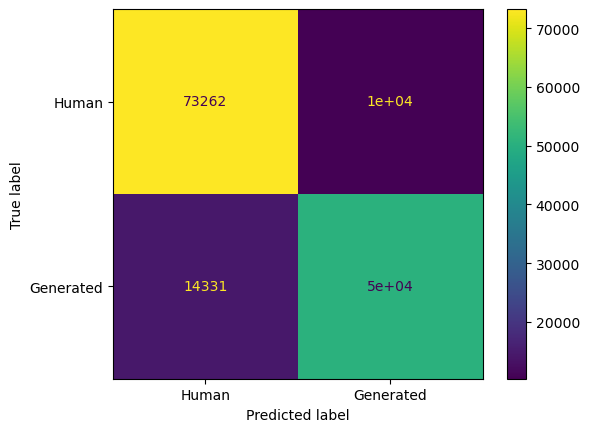

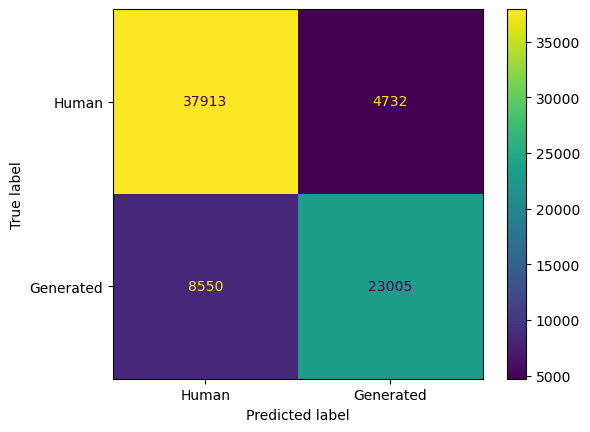

In [12]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef, 
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

def build_rnn_model():
    """Build and compile the RNN-like dense model."""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(train_x_tfidf.shape[1],)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(1e-4),
        metrics=['accuracy']
    )
    return model

# K-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store overall predictions and true labels for validation and test sets
overall_valid_true, overall_valid_pred = [], []
overall_test_true, overall_test_pred = [], []

fold = 1

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(train_x_tfidf):
    print(f"\n\n--- Fold {fold} ---")

    # Split data for the current fold
    X_train, X_val = train_x_tfidf[train_index], train_x_tfidf[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    # Build and train the model
    model = build_rnn_model()
    model.fit(
        X_train,
        y_train,
        epochs=5,
        validation_data=(valid_x_tfidf, valid_y),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    )

    # Validation predictions
    val_pred_prob = model.predict(X_val)
    val_pred_y = (val_pred_prob > 0.5).astype(int).flatten()
    overall_valid_true.extend(y_val)
    overall_valid_pred.extend(val_pred_y)

    # Test predictions
    test_pred_prob = model.predict(test_x_tfidf)
    test_pred_y = (test_pred_prob > 0.5).astype(int).flatten()
    overall_test_true.extend(test_y)
    overall_test_pred.extend(test_pred_y)

    fold += 1

# Compute overall metrics for validation
overall_valid_accuracy = accuracy_score(overall_valid_true, overall_valid_pred)
overall_valid_f1 = f1_score(overall_valid_true, overall_valid_pred)
overall_valid_mcc = matthews_corrcoef(overall_valid_true, overall_valid_pred)
overall_valid_cmd = confusion_matrix(overall_valid_true, overall_valid_pred)
overall_valid_report = classification_report(overall_valid_true, overall_valid_pred)

# Compute overall metrics for test
overall_test_accuracy = accuracy_score(overall_test_true, overall_test_pred)
overall_test_f1 = f1_score(overall_test_true, overall_test_pred)
overall_test_mcc = matthews_corrcoef(overall_test_true, overall_test_pred)
overall_test_cmd = confusion_matrix(overall_test_true, overall_test_pred)
overall_test_report = classification_report(overall_test_true, overall_test_pred)

# Display overall validation metrics
print("\n\n--- Overall Validation Metrics ---")
print(f"Accuracy: {overall_valid_accuracy}")
print(f"F1 Score: {overall_valid_f1}")
print(f"MCC: {overall_valid_mcc}")
print("Confusion Matrix:\n", overall_valid_cmd)
print("Classification Report:\n", overall_valid_report)

# Display overall test metrics
print("\n\n--- Overall Test Metrics ---")
print(f"Accuracy: {overall_test_accuracy}")
print(f"F1 Score: {overall_test_f1}")
print(f"MCC: {overall_test_mcc}")
print("Confusion Matrix:\n", overall_test_cmd)
print("Classification Report:\n", overall_test_report)

# Plot confusion matrices
ConfusionMatrixDisplay(confusion_matrix=overall_valid_cmd, display_labels=['Human', 'Generated']).plot()
ConfusionMatrixDisplay(confusion_matrix=overall_test_cmd, display_labels=['Human', 'Generated']).plot()



--- Fold 1 ---


--- Fold 2 ---


--- Fold 3 ---


--- Fold 4 ---


--- Fold 5 ---


--- Overall Validation Metrics ---
Accuracy: 0.8063098880069002
F1 Score: 0.7763426134860486
MCC: 0.6056328973643488
Confusion Matrix:
 [[69771 13811]
 [14933 49887]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83     83582
           1       0.78      0.77      0.78     64820

    accuracy                           0.81    148402
   macro avg       0.80      0.80      0.80    148402
weighted avg       0.81      0.81      0.81    148402



--- Overall Test Metrics ---
Accuracy: 0.7893800539083557
F1 Score: 0.7476261223435179
MCC: 0.5673255432867403
Confusion Matrix:
 [[35424  7221]
 [ 8407 23148]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82     42645
           1       0.76      0.73      0.75     31555

    accuracy                           0.79 

NameError: name 'joblib' is not defined

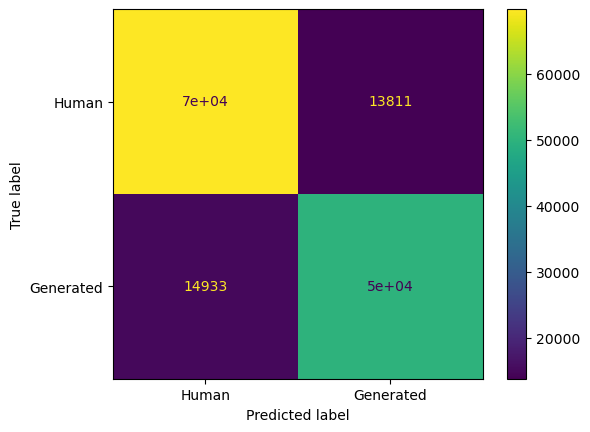

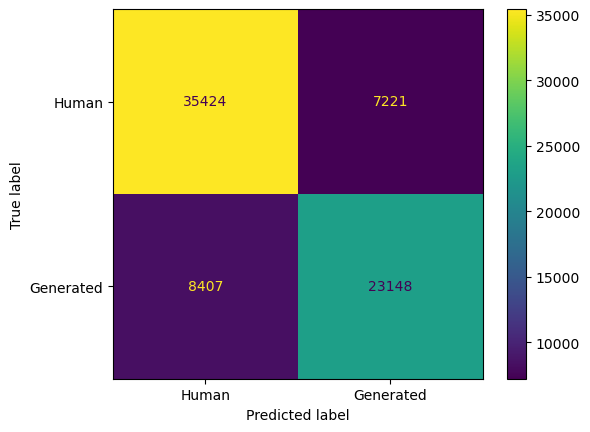

In [13]:
import numpy as np
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef, 
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store overall predictions and true labels for validation and test sets
overall_valid_true, overall_valid_pred = [], []
overall_test_true, overall_test_pred = [], []

fold = 1

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(train_x_tfidf):
    print(f"\n\n--- Fold {fold} ---")

    # Split data for the current fold
    X_train, X_val = train_x_tfidf[train_index], train_x_tfidf[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    # Train the SVM model
    svm_model = LinearSVC()
    svm_model.fit(X_train, y_train)

    # Validation predictions
    val_pred_y = svm_model.predict(X_val)
    overall_valid_true.extend(y_val)
    overall_valid_pred.extend(val_pred_y)

    # Test predictions
    test_pred_y = svm_model.predict(test_x_tfidf)
    overall_test_true.extend(test_y)
    overall_test_pred.extend(test_pred_y)

    fold += 1

# Compute overall metrics for validation
overall_valid_accuracy = accuracy_score(overall_valid_true, overall_valid_pred)
overall_valid_f1 = f1_score(overall_valid_true, overall_valid_pred)
overall_valid_mcc = matthews_corrcoef(overall_valid_true, overall_valid_pred)
overall_valid_cmd = confusion_matrix(overall_valid_true, overall_valid_pred)
overall_valid_report = classification_report(overall_valid_true, overall_valid_pred)

# Compute overall metrics for test
overall_test_accuracy = accuracy_score(overall_test_true, overall_test_pred)
overall_test_f1 = f1_score(overall_test_true, overall_test_pred)
overall_test_mcc = matthews_corrcoef(overall_test_true, overall_test_pred)
overall_test_cmd = confusion_matrix(overall_test_true, overall_test_pred)
overall_test_report = classification_report(overall_test_true, overall_test_pred)

# Display overall validation metrics
print("\n\n--- Overall Validation Metrics ---")
print(f"Accuracy: {overall_valid_accuracy}")
print(f"F1 Score: {overall_valid_f1}")
print(f"MCC: {overall_valid_mcc}")
print("Confusion Matrix:\n", overall_valid_cmd)
print("Classification Report:\n", overall_valid_report)

# Display overall test metrics
print("\n\n--- Overall Test Metrics ---")
print(f"Accuracy: {overall_test_accuracy}")
print(f"F1 Score: {overall_test_f1}")
print(f"MCC: {overall_test_mcc}")
print("Confusion Matrix:\n", overall_test_cmd)
print("Classification Report:\n", overall_test_report)

# Plot confusion matrices
ConfusionMatrixDisplay(confusion_matrix=overall_valid_cmd, display_labels=['Human', 'Generated']).plot()
ConfusionMatrixDisplay(confusion_matrix=overall_test_cmd, display_labels=['Human', 'Generated']).plot()

joblib.dump(svm_model, 'svm_model_Kfold.joblib')


In [19]:
import joblib

In [20]:
joblib.dump(svm_model, 'svm_model_Kfold.joblib')

['svm_model_Kfold.joblib']



--- Fold 1 ---


--- Fold 2 ---


--- Fold 3 ---


--- Fold 4 ---


--- Fold 5 ---


--- Overall Validation Metrics ---
Accuracy: 0.6396814059109716
F1 Score: 0.4426748936879847
MCC: 0.2550051416586303
Confusion Matrix:
 [[73694  9888]
 [43584 21236]]
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.88      0.73     83582
           1       0.68      0.33      0.44     64820

    accuracy                           0.64    148402
   macro avg       0.66      0.60      0.59    148402
weighted avg       0.65      0.64      0.61    148402



--- Overall Test Metrics ---
Accuracy: 0.6544204851752021
F1 Score: 0.4286287267703552
MCC: 0.28069829080984404
Confusion Matrix:
 [[38940  3705]
 [21937  9618]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.91      0.75     42645
           1       0.72      0.30      0.43     31555

    accuracy                           0.65

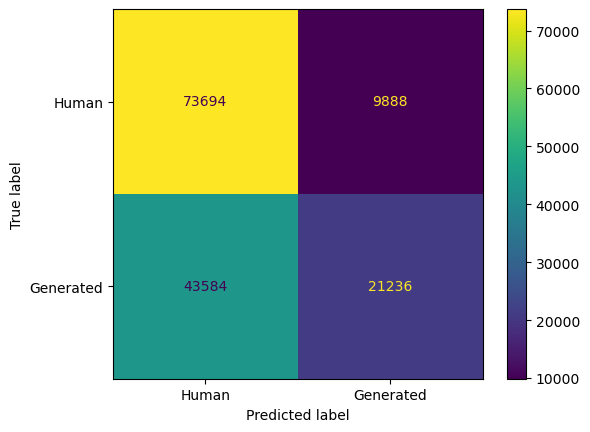

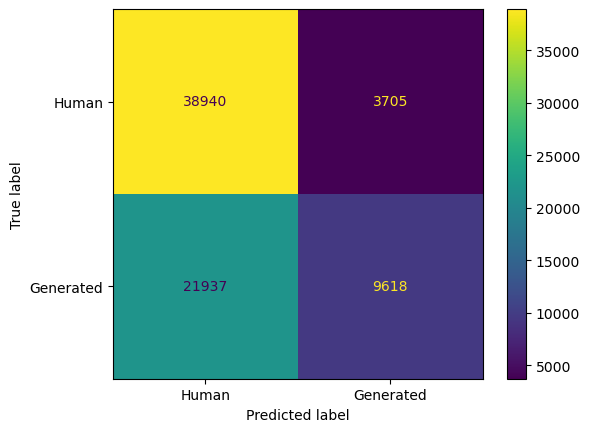

In [14]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef, 
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# K-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store overall predictions and true labels for validation and test sets
overall_valid_true, overall_valid_pred = [], []
overall_test_true, overall_test_pred = [], []

fold = 1

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(train_x_tfidf):
    print(f"\n\n--- Fold {fold} ---")

    # Split data for the current fold
    X_train, X_val = train_x_tfidf[train_index], train_x_tfidf[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    # Train the KNN model
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train, y_train)

    # Validation predictions
    val_pred_y = knn_model.predict(X_val)
    overall_valid_true.extend(y_val)
    overall_valid_pred.extend(val_pred_y)

    # Test predictions
    test_pred_y = knn_model.predict(test_x_tfidf)
    overall_test_true.extend(test_y)
    overall_test_pred.extend(test_pred_y)

    fold += 1

# Compute overall metrics for validation
overall_valid_accuracy = accuracy_score(overall_valid_true, overall_valid_pred)
overall_valid_f1 = f1_score(overall_valid_true, overall_valid_pred)
overall_valid_mcc = matthews_corrcoef(overall_valid_true, overall_valid_pred)
overall_valid_cmd = confusion_matrix(overall_valid_true, overall_valid_pred)
overall_valid_report = classification_report(overall_valid_true, overall_valid_pred)

# Compute overall metrics for test
overall_test_accuracy = accuracy_score(overall_test_true, overall_test_pred)
overall_test_f1 = f1_score(overall_test_true, overall_test_pred)
overall_test_mcc = matthews_corrcoef(overall_test_true, overall_test_pred)
overall_test_cmd = confusion_matrix(overall_test_true, overall_test_pred)
overall_test_report = classification_report(overall_test_true, overall_test_pred)

# Display overall validation metrics
print("\n\n--- Overall Validation Metrics ---")
print(f"Accuracy: {overall_valid_accuracy}")
print(f"F1 Score: {overall_valid_f1}")
print(f"MCC: {overall_valid_mcc}")
print("Confusion Matrix:\n", overall_valid_cmd)
print("Classification Report:\n", overall_valid_report)

# Display overall test metrics
print("\n\n--- Overall Test Metrics ---")
print(f"Accuracy: {overall_test_accuracy}")
print(f"F1 Score: {overall_test_f1}")
print(f"MCC: {overall_test_mcc}")
print("Confusion Matrix:\n", overall_test_cmd)
print("Classification Report:\n", overall_test_report)

# Plot confusion matrices
ConfusionMatrixDisplay(confusion_matrix=overall_valid_cmd, display_labels=['Human', 'Generated']).plot()
ConfusionMatrixDisplay(confusion_matrix=overall_test_cmd, display_labels=['Human', 'Generated']).plot()

#joblib.dump(knn_model, 'knn_model_Kfold.joblib')


In [21]:
joblib.dump(knn_model, 'knn_model_Kfold.joblib')

['knn_model_Kfold.joblib']



--- Fold 1 ---


--- Fold 2 ---


--- Fold 3 ---


--- Fold 4 ---


--- Fold 5 ---


--- Overall Validation Metrics ---
Accuracy: 0.7398013503861134
F1 Score: 0.6985730344095422
MCC: 0.46984393033916155
Confusion Matrix:
 [[65043 18539]
 [20075 44745]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.78      0.77     83582
           1       0.71      0.69      0.70     64820

    accuracy                           0.74    148402
   macro avg       0.74      0.73      0.73    148402
weighted avg       0.74      0.74      0.74    148402



--- Overall Test Metrics ---
Accuracy: 0.7314824797843665
F1 Score: 0.678665892523063
MCC: 0.4483897881456962
Confusion Matrix:
 [[33236  9409]
 [10515 21040]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.78      0.77     42645
           1       0.69      0.67      0.68     31555

    accuracy                           0.73 

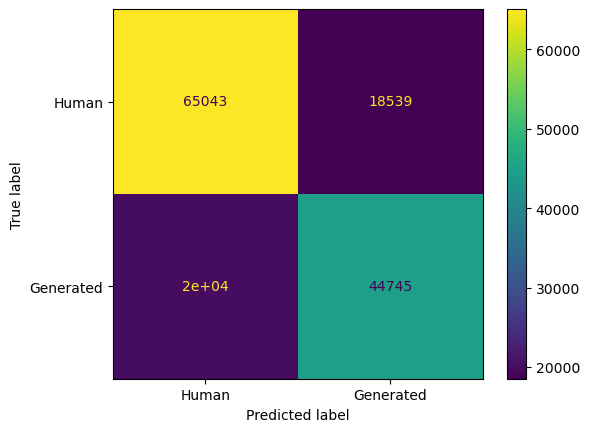

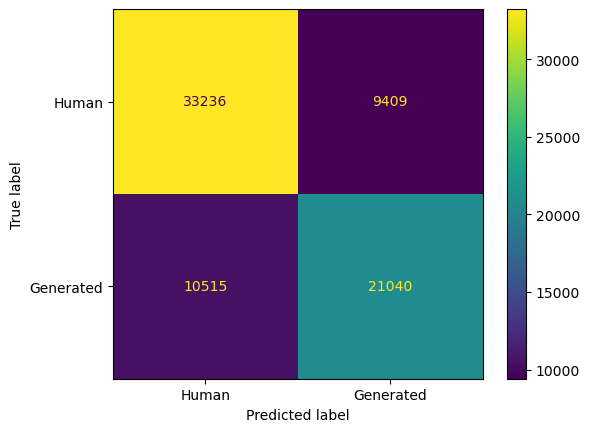

In [15]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef, 
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# K-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store overall predictions and true labels for validation and test sets
overall_valid_true, overall_valid_pred = [], []
overall_test_true, overall_test_pred = [], []

fold = 1

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(train_x_tfidf):
    print(f"\n\n--- Fold {fold} ---")

    # Split data for the current fold
    X_train, X_val = train_x_tfidf[train_index], train_x_tfidf[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    # Train the Decision Tree model
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train, y_train)

    # Validation predictions
    val_pred_y = dt_model.predict(X_val)
    overall_valid_true.extend(y_val)
    overall_valid_pred.extend(val_pred_y)

    # Test predictions
    test_pred_y = dt_model.predict(test_x_tfidf)
    overall_test_true.extend(test_y)
    overall_test_pred.extend(test_pred_y)

    fold += 1

# Compute overall metrics for validation
overall_valid_accuracy = accuracy_score(overall_valid_true, overall_valid_pred)
overall_valid_f1 = f1_score(overall_valid_true, overall_valid_pred)
overall_valid_mcc = matthews_corrcoef(overall_valid_true, overall_valid_pred)
overall_valid_cmd = confusion_matrix(overall_valid_true, overall_valid_pred)
overall_valid_report = classification_report(overall_valid_true, overall_valid_pred)

# Compute overall metrics for test
overall_test_accuracy = accuracy_score(overall_test_true, overall_test_pred)
overall_test_f1 = f1_score(overall_test_true, overall_test_pred)
overall_test_mcc = matthews_corrcoef(overall_test_true, overall_test_pred)
overall_test_cmd = confusion_matrix(overall_test_true, overall_test_pred)
overall_test_report = classification_report(overall_test_true, overall_test_pred)

# Display overall validation metrics
print("\n\n--- Overall Validation Metrics ---")
print(f"Accuracy: {overall_valid_accuracy}")
print(f"F1 Score: {overall_valid_f1}")
print(f"MCC: {overall_valid_mcc}")
print("Confusion Matrix:\n", overall_valid_cmd)
print("Classification Report:\n", overall_valid_report)

# Display overall test metrics
print("\n\n--- Overall Test Metrics ---")
print(f"Accuracy: {overall_test_accuracy}")
print(f"F1 Score: {overall_test_f1}")
print(f"MCC: {overall_test_mcc}")
print("Confusion Matrix:\n", overall_test_cmd)
print("Classification Report:\n", overall_test_report)

# Plot confusion matrices
ConfusionMatrixDisplay(confusion_matrix=overall_valid_cmd, display_labels=['Human', 'Generated']).plot()
ConfusionMatrixDisplay(confusion_matrix=overall_test_cmd, display_labels=['Human', 'Generated']).plot()

#joblib.dump(dt_model, 'dt_model_Kfold.joblib')


In [22]:
joblib.dump(dt_model, 'dt_model_Kfold.joblib')

['dt_model_Kfold.joblib']



--- Fold 1 ---


--- Fold 2 ---


--- Fold 3 ---


--- Fold 4 ---


--- Fold 5 ---


--- Overall Validation Metrics ---
Accuracy: 0.7295184701014811
F1 Score: 0.6751165501165501
MCC: 0.4459792528306545
Confusion Matrix:
 [[66556 17026]
 [23114 41706]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.80      0.77     83582
           1       0.71      0.64      0.68     64820

    accuracy                           0.73    148402
   macro avg       0.73      0.72      0.72    148402
weighted avg       0.73      0.73      0.73    148402



--- Overall Test Metrics ---
Accuracy: 0.7165902964959568
F1 Score: 0.6485149342292199
MCC: 0.41402783749326455
Confusion Matrix:
 [[33771  8874]
 [12155 19400]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.79      0.76     42645
           1       0.69      0.61      0.65     31555

    accuracy                           0.72

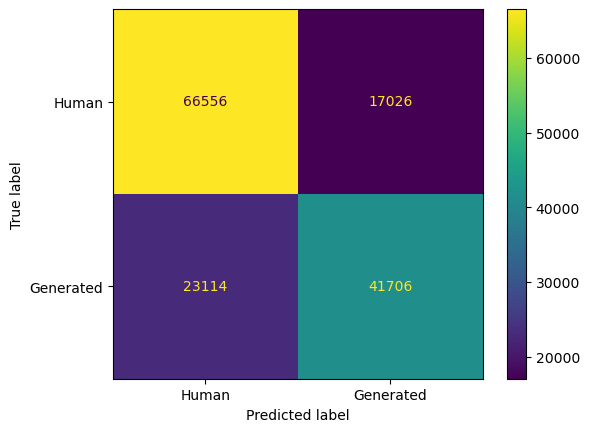

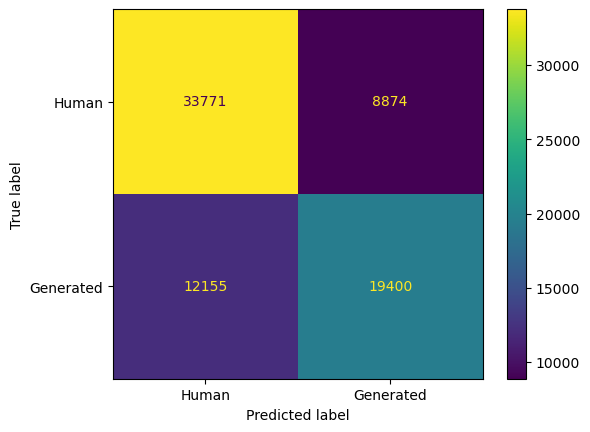

In [16]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef, 
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# K-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store overall predictions and true labels for validation and test sets
overall_valid_true, overall_valid_pred = [], []
overall_test_true, overall_test_pred = [], []

fold = 1

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(train_x_tfidf):
    print(f"\n\n--- Fold {fold} ---")

    # Split data for the current fold
    X_train, X_val = train_x_tfidf[train_index], train_x_tfidf[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    # Train the AdaBoost model
    dt_stump = DecisionTreeClassifier(max_depth=1, random_state=42)
    ada_model = AdaBoostClassifier(estimator=dt_stump, n_estimators=100, algorithm='SAMME', random_state=42)
    ada_model.fit(X_train, y_train)

    # Validation predictions
    val_pred_y = ada_model.predict(X_val)
    overall_valid_true.extend(y_val)
    overall_valid_pred.extend(val_pred_y)

    # Test predictions
    test_pred_y = ada_model.predict(test_x_tfidf)
    overall_test_true.extend(test_y)
    overall_test_pred.extend(test_pred_y)

    fold += 1

# Compute overall metrics for validation
overall_valid_accuracy = accuracy_score(overall_valid_true, overall_valid_pred)
overall_valid_f1 = f1_score(overall_valid_true, overall_valid_pred)
overall_valid_mcc = matthews_corrcoef(overall_valid_true, overall_valid_pred)
overall_valid_cmd = confusion_matrix(overall_valid_true, overall_valid_pred)
overall_valid_report = classification_report(overall_valid_true, overall_valid_pred)

# Compute overall metrics for test
overall_test_accuracy = accuracy_score(overall_test_true, overall_test_pred)
overall_test_f1 = f1_score(overall_test_true, overall_test_pred)
overall_test_mcc = matthews_corrcoef(overall_test_true, overall_test_pred)
overall_test_cmd = confusion_matrix(overall_test_true, overall_test_pred)
overall_test_report = classification_report(overall_test_true, overall_test_pred)

# Display overall validation metrics
print("\n\n--- Overall Validation Metrics ---")
print(f"Accuracy: {overall_valid_accuracy}")
print(f"F1 Score: {overall_valid_f1}")
print(f"MCC: {overall_valid_mcc}")
print("Confusion Matrix:\n", overall_valid_cmd)
print("Classification Report:\n", overall_valid_report)

# Display overall test metrics
print("\n\n--- Overall Test Metrics ---")
print(f"Accuracy: {overall_test_accuracy}")
print(f"F1 Score: {overall_test_f1}")
print(f"MCC: {overall_test_mcc}")
print("Confusion Matrix:\n", overall_test_cmd)
print("Classification Report:\n", overall_test_report)

# Plot confusion matrices
ConfusionMatrixDisplay(confusion_matrix=overall_valid_cmd, display_labels=['Human', 'Generated']).plot()
ConfusionMatrixDisplay(confusion_matrix=overall_test_cmd, display_labels=['Human', 'Generated']).plot()

#joblib.dump(ada_model, 'ada_model_Kfold.joblib')

In [23]:
joblib.dump(ada_model, 'ada_model_Kfold.joblib')

['ada_model_Kfold.joblib']

In [17]:
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef, 
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# K-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store overall predictions and true labels for validation and test sets
overall_valid_true, overall_valid_pred = [], []
overall_test_true, overall_test_pred = [], []

fold = 1

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(train_x_tfidf):
    print(f"\n\n--- Fold {fold} ---")

    # Split data for the current fold
    X_train, X_val = train_x_tfidf[train_index], train_x_tfidf[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    # Train the Bagging model
    base_estimator = DecisionTreeClassifier()
    bagging_model = BaggingClassifier(estimator=base_estimator, n_estimators=100, random_state=42)
    bagging_model.fit(X_train, y_train)

    # Validation predictions
    val_pred_y = bagging_model.predict(X_val)
    overall_valid_true.extend(y_val)
    overall_valid_pred.extend(val_pred_y)

    # Test predictions
    test_pred_y = bagging_model.predict(test_x_tfidf)
    overall_test_true.extend(test_y)
    overall_test_pred.extend(test_pred_y)

    fold += 1

# Compute overall metrics for validation
overall_valid_accuracy = accuracy_score(overall_valid_true, overall_valid_pred)
overall_valid_f1 = f1_score(overall_valid_true, overall_valid_pred)
overall_valid_mcc = matthews_corrcoef(overall_valid_true, overall_valid_pred)
overall_valid_cmd = confusion_matrix(overall_valid_true, overall_valid_pred)
overall_valid_report = classification_report(overall_valid_true, overall_valid_pred)

# Compute overall metrics for test
overall_test_accuracy = accuracy_score(overall_test_true, overall_test_pred)
overall_test_f1 = f1_score(overall_test_true, overall_test_pred)
overall_test_mcc = matthews_corrcoef(overall_test_true, overall_test_pred)
overall_test_cmd = confusion_matrix(overall_test_true, overall_test_pred)
overall_test_report = classification_report(overall_test_true, overall_test_pred)

# Display overall validation metrics
print("\n\n--- Overall Validation Metrics ---")
print(f"Accuracy: {overall_valid_accuracy}")
print(f"F1 Score: {overall_valid_f1}")
print(f"MCC: {overall_valid_mcc}")
print("Confusion Matrix:\n", overall_valid_cmd)
print("Classification Report:\n", overall_valid_report)

# Display overall test metrics
print("\n\n--- Overall Test Metrics ---")
print(f"Accuracy: {overall_test_accuracy}")
print(f"F1 Score: {overall_test_f1}")
print(f"MCC: {overall_test_mcc}")
print("Confusion Matrix:\n", overall_test_cmd)
print("Classification Report:\n", overall_test_report)

# Plot confusion matrices
ConfusionMatrixDisplay(confusion_matrix=overall_valid_cmd, display_labels=['Human', 'Generated']).plot()
ConfusionMatrixDisplay(confusion_matrix=overall_test_cmd, display_labels=['Human', 'Generated']).plot()

#joblib.dump(bagging_model, 'bagging_model_Kfold.joblib')




--- Fold 1 ---


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef, 
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
import joblib

# K-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store overall predictions and true labels for validation and test sets
overall_valid_true, overall_valid_pred = [], []
overall_test_true, overall_test_pred = [], []

fold = 1

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(train_x_tfidf):
    print(f"\n\n--- Fold {fold} ---")

    # Split data for the current fold
    X_train, X_val = train_x_tfidf[train_index], train_x_tfidf[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    # Train the Gradient Boosting model
    gradient_boosting_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gradient_boosting_model.fit(X_train, y_train)

    # Validation predictions
    val_pred_y = gradient_boosting_model.predict(X_val)
    overall_valid_true.extend(y_val)
    overall_valid_pred.extend(val_pred_y)

    # Test predictions
    test_pred_y = gradient_boosting_model.predict(test_x_tfidf)
    overall_test_true.extend(test_y)
    overall_test_pred.extend(test_pred_y)

    fold += 1

# Compute overall metrics for validation
overall_valid_accuracy = accuracy_score(overall_valid_true, overall_valid_pred)
overall_valid_f1 = f1_score(overall_valid_true, overall_valid_pred)
overall_valid_mcc = matthews_corrcoef(overall_valid_true, overall_valid_pred)
overall_valid_cmd = confusion_matrix(overall_valid_true, overall_valid_pred)
overall_valid_report = classification_report(overall_valid_true, overall_valid_pred)

# Compute overall metrics for test
overall_test_accuracy = accuracy_score(overall_test_true, overall_test_pred)
overall_test_f1 = f1_score(overall_test_true, overall_test_pred)
overall_test_mcc = matthews_corrcoef(overall_test_true, overall_test_pred)
overall_test_cmd = confusion_matrix(overall_test_true, overall_test_pred)
overall_test_report = classification_report(overall_test_true, overall_test_pred)

# Display overall validation metrics
print("\n\n--- Overall Validation Metrics ---")
print(f"Accuracy: {overall_valid_accuracy}")
print(f"F1 Score: {overall_valid_f1}")
print(f"MCC: {overall_valid_mcc}")
print("Confusion Matrix:\n", overall_valid_cmd)
print("Classification Report:\n", overall_valid_report)

# Display overall test metrics
print("\n\n--- Overall Test Metrics ---")
print(f"Accuracy: {overall_test_accuracy}")
print(f"F1 Score: {overall_test_f1}")
print(f"MCC: {overall_test_mcc}")
print("Confusion Matrix:\n", overall_test_cmd)
print("Classification Report:\n", overall_test_report)

# Plot confusion matrices
ConfusionMatrixDisplay(confusion_matrix=overall_valid_cmd, display_labels=['Human', 'Generated']).plot()
ConfusionMatrixDisplay(confusion_matrix=overall_test_cmd, display_labels=['Human', 'Generated']).plot()

# Save the model
#joblib.dump(gradient_boosting_model, 'gradient_boosting_model_Kfold.joblib')




--- Fold 1 ---


--- Fold 2 ---


--- Fold 3 ---


--- Fold 4 ---


--- Fold 5 ---


--- Overall Validation Metrics ---
Accuracy: 0.8001778951766149
F1 Score: 0.747526691300424
MCC: 0.5938040423724154
Confusion Matrix:
 [[74848  8734]
 [20920 43900]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.83     83582
           1       0.83      0.68      0.75     64820

    accuracy                           0.80    148402
   macro avg       0.81      0.79      0.79    148402
weighted avg       0.80      0.80      0.80    148402



--- Overall Test Metrics ---
Accuracy: 0.8080323450134771
F1 Score: 0.7394167794811752
MCC: 0.6111906550052726
Confusion Matrix:
 [[39747  2898]
 [11346 20209]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85     42645
           1       0.87      0.64      0.74     31555

    accuracy                           0.81  

['random_forest_model_Kfold.joblib']

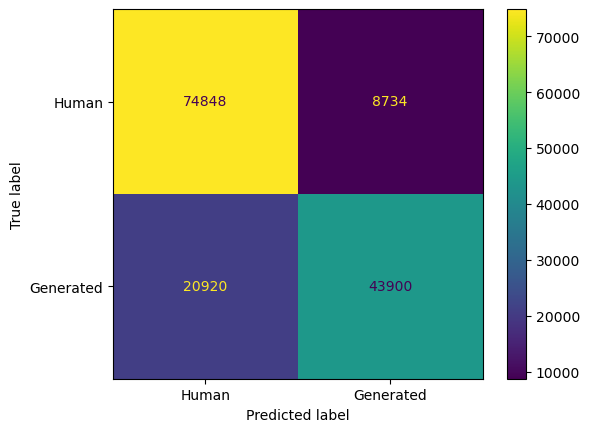

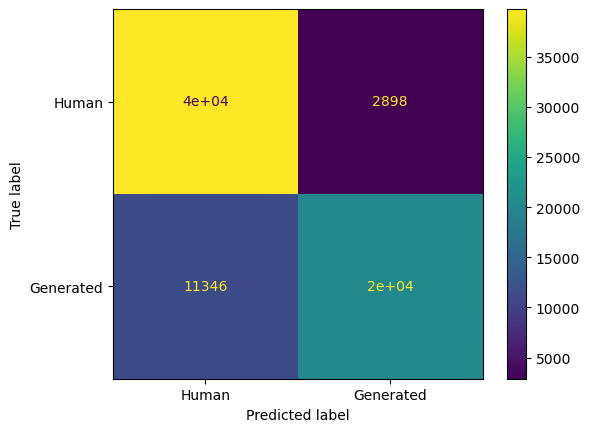

In [24]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef, 
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
import joblib

# K-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store overall predictions and true labels for validation and test sets
overall_valid_true, overall_valid_pred = [], []
overall_test_true, overall_test_pred = [], []

fold = 1

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(train_x_tfidf):
    print(f"\n\n--- Fold {fold} ---")

    # Split data for the current fold
    X_train, X_val = train_x_tfidf[train_index], train_x_tfidf[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    # Train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)

    # Validation predictions
    val_pred_y = rf_model.predict(X_val)
    overall_valid_true.extend(y_val)
    overall_valid_pred.extend(val_pred_y)

    # Test predictions
    test_pred_y = rf_model.predict(test_x_tfidf)
    overall_test_true.extend(test_y)
    overall_test_pred.extend(test_pred_y)

    fold += 1

# Compute overall metrics for validation
overall_valid_accuracy = accuracy_score(overall_valid_true, overall_valid_pred)
overall_valid_f1 = f1_score(overall_valid_true, overall_valid_pred)
overall_valid_mcc = matthews_corrcoef(overall_valid_true, overall_valid_pred)
overall_valid_cmd = confusion_matrix(overall_valid_true, overall_valid_pred)
overall_valid_report = classification_report(overall_valid_true, overall_valid_pred)

# Compute overall metrics for test
overall_test_accuracy = accuracy_score(overall_test_true, overall_test_pred)
overall_test_f1 = f1_score(overall_test_true, overall_test_pred)
overall_test_mcc = matthews_corrcoef(overall_test_true, overall_test_pred)
overall_test_cmd = confusion_matrix(overall_test_true, overall_test_pred)
overall_test_report = classification_report(overall_test_true, overall_test_pred)

# Display overall validation metrics
print("\n\n--- Overall Validation Metrics ---")
print(f"Accuracy: {overall_valid_accuracy}")
print(f"F1 Score: {overall_valid_f1}")
print(f"MCC: {overall_valid_mcc}")
print("Confusion Matrix:\n", overall_valid_cmd)
print("Classification Report:\n", overall_valid_report)

# Display overall test metrics
print("\n\n--- Overall Test Metrics ---")
print(f"Accuracy: {overall_test_accuracy}")
print(f"F1 Score: {overall_test_f1}")
print(f"MCC: {overall_test_mcc}")
print("Confusion Matrix:\n", overall_test_cmd)
print("Classification Report:\n", overall_test_report)

# Plot confusion matrices
ConfusionMatrixDisplay(confusion_matrix=overall_valid_cmd, display_labels=['Human', 'Generated']).plot()
ConfusionMatrixDisplay(confusion_matrix=overall_test_cmd, display_labels=['Human', 'Generated']).plot()

# Save the model
joblib.dump(rf_model, 'random_forest_model_Kfold.joblib')




--- Fold 1 ---


--- Fold 2 ---


--- Fold 3 ---


--- Fold 4 ---


--- Fold 5 ---


--- Overall Validation Metrics ---
Accuracy: 0.7934461799706204
F1 Score: 0.7447901489480389
MCC: 0.5782534175422234
Confusion Matrix:
 [[73021 10561]
 [20092 44728]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.87      0.83     83582
           1       0.81      0.69      0.74     64820

    accuracy                           0.79    148402
   macro avg       0.80      0.78      0.79    148402
weighted avg       0.80      0.79      0.79    148402



--- Overall Test Metrics ---
Accuracy: 0.8149056603773585
F1 Score: 0.7517174054523104
MCC: 0.6243703317291713
Confusion Matrix:
 [[39675  2970]
 [10764 20791]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.93      0.85     42645
           1       0.88      0.66      0.75     31555

    accuracy                           0.81 

['extra_trees_model_Kfold.joblib']

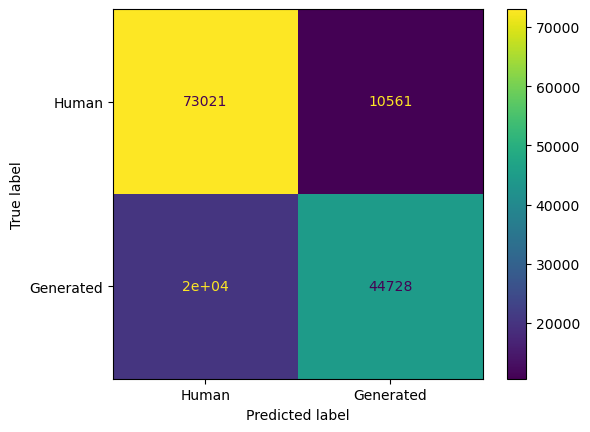

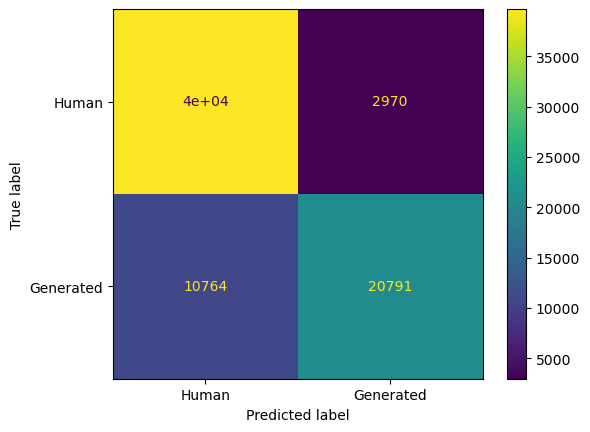

In [25]:
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef, 
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
import joblib

# K-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store overall predictions and true labels for validation and test sets
overall_valid_true, overall_valid_pred = [], []
overall_test_true, overall_test_pred = [], []

fold = 1

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(train_x_tfidf):
    print(f"\n\n--- Fold {fold} ---")

    # Split data for the current fold
    X_train, X_val = train_x_tfidf[train_index], train_x_tfidf[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    # Train the Extra Trees model
    extra_trees_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
    extra_trees_model.fit(X_train, y_train)

    # Validation predictions
    val_pred_y = extra_trees_model.predict(X_val)
    overall_valid_true.extend(y_val)
    overall_valid_pred.extend(val_pred_y)

    # Test predictions
    test_pred_y = extra_trees_model.predict(test_x_tfidf)
    overall_test_true.extend(test_y)
    overall_test_pred.extend(test_pred_y)

    fold += 1

# Compute overall metrics for validation
overall_valid_accuracy = accuracy_score(overall_valid_true, overall_valid_pred)
overall_valid_f1 = f1_score(overall_valid_true, overall_valid_pred)
overall_valid_mcc = matthews_corrcoef(overall_valid_true, overall_valid_pred)
overall_valid_cmd = confusion_matrix(overall_valid_true, overall_valid_pred)
overall_valid_report = classification_report(overall_valid_true, overall_valid_pred)

# Compute overall metrics for test
overall_test_accuracy = accuracy_score(overall_test_true, overall_test_pred)
overall_test_f1 = f1_score(overall_test_true, overall_test_pred)
overall_test_mcc = matthews_corrcoef(overall_test_true, overall_test_pred)
overall_test_cmd = confusion_matrix(overall_test_true, overall_test_pred)
overall_test_report = classification_report(overall_test_true, overall_test_pred)

# Display overall validation metrics
print("\n\n--- Overall Validation Metrics ---")
print(f"Accuracy: {overall_valid_accuracy}")
print(f"F1 Score: {overall_valid_f1}")
print(f"MCC: {overall_valid_mcc}")
print("Confusion Matrix:\n", overall_valid_cmd)
print("Classification Report:\n", overall_valid_report)

# Display overall test metrics
print("\n\n--- Overall Test Metrics ---")
print(f"Accuracy: {overall_test_accuracy}")
print(f"F1 Score: {overall_test_f1}")
print(f"MCC: {overall_test_mcc}")
print("Confusion Matrix:\n", overall_test_cmd)
print("Classification Report:\n", overall_test_report)

# Plot confusion matrices
ConfusionMatrixDisplay(confusion_matrix=overall_valid_cmd, display_labels=['Human', 'Generated']).plot()
ConfusionMatrixDisplay(confusion_matrix=overall_test_cmd, display_labels=['Human', 'Generated']).plot()

# Save the model
joblib.dump(extra_trees_model, 'extra_trees_model_Kfold.joblib')




--- Fold 1 ---


--- Fold 2 ---


--- Fold 3 ---


--- Fold 4 ---


--- Fold 5 ---


--- Overall Validation Metrics ---
Accuracy: 0.8038436139674667
F1 Score: 0.7721865706683362
MCC: 0.6002226220661073
Confusion Matrix:
 [[69957 13625]
 [15485 49335]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83     83582
           1       0.78      0.76      0.77     64820

    accuracy                           0.80    148402
   macro avg       0.80      0.80      0.80    148402
weighted avg       0.80      0.80      0.80    148402



--- Overall Test Metrics ---
Accuracy: 0.7880727762803235
F1 Score: 0.7435458355757784
MCC: 0.5639336977611987
Confusion Matrix:
 [[35679  6966]
 [ 8759 22796]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82     42645
           1       0.77      0.72      0.74     31555

    accuracy                           0.79 

['logistic_regression_model_Kfold.joblib']

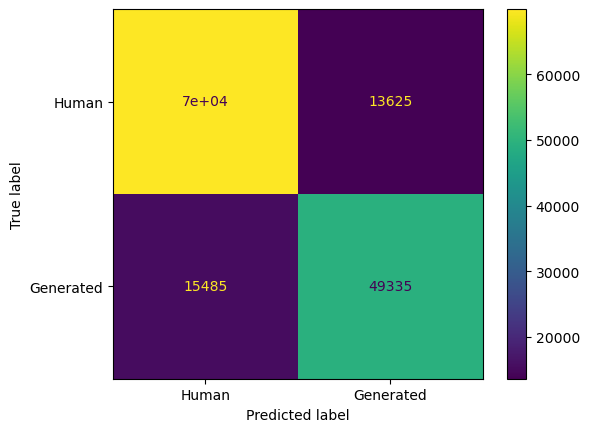

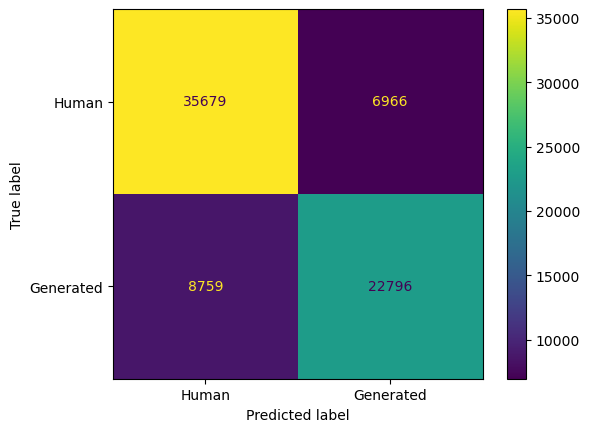

In [26]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef, 
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
import joblib

# K-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store overall predictions and true labels for validation and test sets
overall_valid_true, overall_valid_pred = [], []
overall_test_true, overall_test_pred = [], []

fold = 1

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(train_x_tfidf):
    print(f"\n\n--- Fold {fold} ---")

    # Split data for the current fold
    X_train, X_val = train_x_tfidf[train_index], train_x_tfidf[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    # Train the Logistic Regression model
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train)

    # Validation predictions
    val_pred_y = log_reg.predict(X_val)
    overall_valid_true.extend(y_val)
    overall_valid_pred.extend(val_pred_y)

    # Test predictions
    test_pred_y = log_reg.predict(test_x_tfidf)
    overall_test_true.extend(test_y)
    overall_test_pred.extend(test_pred_y)

    fold += 1

# Compute overall metrics for validation
overall_valid_accuracy = accuracy_score(overall_valid_true, overall_valid_pred)
overall_valid_f1 = f1_score(overall_valid_true, overall_valid_pred)
overall_valid_mcc = matthews_corrcoef(overall_valid_true, overall_valid_pred)
overall_valid_cmd = confusion_matrix(overall_valid_true, overall_valid_pred)
overall_valid_report = classification_report(overall_valid_true, overall_valid_pred)

# Compute overall metrics for test
overall_test_accuracy = accuracy_score(overall_test_true, overall_test_pred)
overall_test_f1 = f1_score(overall_test_true, overall_test_pred)
overall_test_mcc = matthews_corrcoef(overall_test_true, overall_test_pred)
overall_test_cmd = confusion_matrix(overall_test_true, overall_test_pred)
overall_test_report = classification_report(overall_test_true, overall_test_pred)

# Display overall validation metrics
print("\n\n--- Overall Validation Metrics ---")
print(f"Accuracy: {overall_valid_accuracy}")
print(f"F1 Score: {overall_valid_f1}")
print(f"MCC: {overall_valid_mcc}")
print("Confusion Matrix:\n", overall_valid_cmd)
print("Classification Report:\n", overall_valid_report)

# Display overall test metrics
print("\n\n--- Overall Test Metrics ---")
print(f"Accuracy: {overall_test_accuracy}")
print(f"F1 Score: {overall_test_f1}")
print(f"MCC: {overall_test_mcc}")
print("Confusion Matrix:\n", overall_test_cmd)
print("Classification Report:\n", overall_test_report)

# Plot confusion matrices
ConfusionMatrixDisplay(confusion_matrix=overall_valid_cmd, display_labels=['Human', 'Generated']).plot()
ConfusionMatrixDisplay(confusion_matrix=overall_test_cmd, display_labels=['Human', 'Generated']).plot()

# Save the model
joblib.dump(log_reg, 'logistic_regression_model_Kfold.joblib')




--- Fold 1 ---


--- Fold 2 ---


--- Fold 3 ---


--- Fold 4 ---


--- Fold 5 ---


--- Overall Validation Metrics ---
Accuracy: 0.8045915823236883
F1 Score: 0.7744514703937903
MCC: 0.6021632447353978
Confusion Matrix:
 [[69617 13965]
 [15034 49786]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83     83582
           1       0.78      0.77      0.77     64820

    accuracy                           0.80    148402
   macro avg       0.80      0.80      0.80    148402
weighted avg       0.80      0.80      0.80    148402



--- Overall Test Metrics ---
Accuracy: 0.8131266846361186
F1 Score: 0.773571965119697
MCC: 0.6155750340957629
Confusion Matrix:
 [[36648  5997]
 [ 7869 23686]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84     42645
           1       0.80      0.75      0.77     31555

    accuracy                           0.81  

['mlp_model_Kfold.joblib']

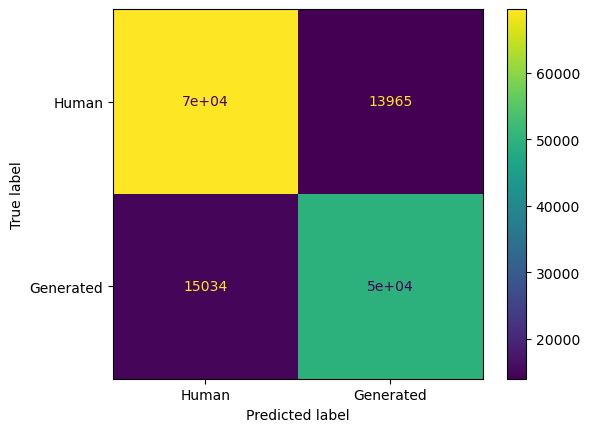

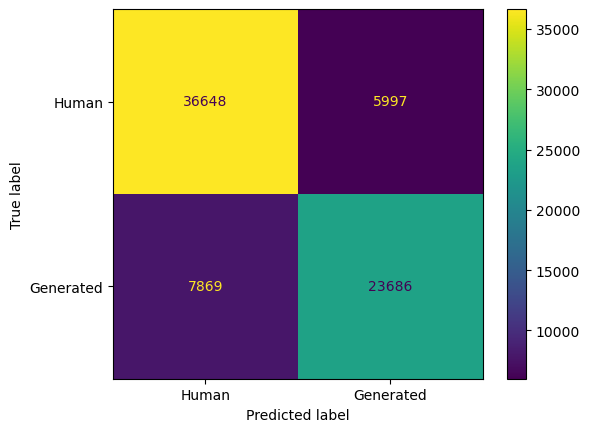

In [27]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef, 
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
import joblib

# K-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store overall predictions and true labels for validation and test sets
overall_valid_true, overall_valid_pred = [], []
overall_test_true, overall_test_pred = [], []

fold = 1

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(train_x_tfidf):
    print(f"\n\n--- Fold {fold} ---")

    # Split data for the current fold
    X_train, X_val = train_x_tfidf[train_index], train_x_tfidf[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    # Train the MLP model
    mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
    mlp_model.fit(X_train, y_train)

    # Validation predictions
    val_pred_y = mlp_model.predict(X_val)
    overall_valid_true.extend(y_val)
    overall_valid_pred.extend(val_pred_y)

    # Test predictions
    test_pred_y = mlp_model.predict(test_x_tfidf)
    overall_test_true.extend(test_y)
    overall_test_pred.extend(test_pred_y)

    fold += 1

# Compute overall metrics for validation
overall_valid_accuracy = accuracy_score(overall_valid_true, overall_valid_pred)
overall_valid_f1 = f1_score(overall_valid_true, overall_valid_pred)
overall_valid_mcc = matthews_corrcoef(overall_valid_true, overall_valid_pred)
overall_valid_cmd = confusion_matrix(overall_valid_true, overall_valid_pred)
overall_valid_report = classification_report(overall_valid_true, overall_valid_pred)

# Compute overall metrics for test
overall_test_accuracy = accuracy_score(overall_test_true, overall_test_pred)
overall_test_f1 = f1_score(overall_test_true, overall_test_pred)
overall_test_mcc = matthews_corrcoef(overall_test_true, overall_test_pred)
overall_test_cmd = confusion_matrix(overall_test_true, overall_test_pred)
overall_test_report = classification_report(overall_test_true, overall_test_pred)

# Display overall validation metrics
print("\n\n--- Overall Validation Metrics ---")
print(f"Accuracy: {overall_valid_accuracy}")
print(f"F1 Score: {overall_valid_f1}")
print(f"MCC: {overall_valid_mcc}")
print("Confusion Matrix:\n", overall_valid_cmd)
print("Classification Report:\n", overall_valid_report)

# Display overall test metrics
print("\n\n--- Overall Test Metrics ---")
print(f"Accuracy: {overall_test_accuracy}")
print(f"F1 Score: {overall_test_f1}")
print(f"MCC: {overall_test_mcc}")
print("Confusion Matrix:\n", overall_test_cmd)
print("Classification Report:\n", overall_test_report)

# Plot confusion matrices
ConfusionMatrixDisplay(confusion_matrix=overall_valid_cmd, display_labels=['Human', 'Generated']).plot()
ConfusionMatrixDisplay(confusion_matrix=overall_test_cmd, display_labels=['Human', 'Generated']).plot()

# Save the model
joblib.dump(mlp_model, 'mlp_model_Kfold.joblib')


In [ ]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef, 
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
import joblib

# K-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store overall predictions and true labels for validation and test sets
overall_valid_true, overall_valid_pred = [], []
overall_test_true, overall_test_pred = [], []

fold = 1

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(train_x_tfidf):
    print(f"\n\n--- Fold {fold} ---")

    # Split data for the current fold
    X_train, X_val = train_x_tfidf[train_index], train_x_tfidf[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    # Train the LDA model
    lda_model = LinearDiscriminantAnalysis()
    lda_model.fit(X_train, y_train)

    # Validation predictions
    val_pred_y = lda_model.predict(X_val)
    overall_valid_true.extend(y_val)
    overall_valid_pred.extend(val_pred_y)

    # Test predictions
    test_pred_y = lda_model.predict(test_x_tfidf)
    overall_test_true.extend(test_y)
    overall_test_pred.extend(test_pred_y)

    fold += 1

# Compute overall metrics for validation
overall_valid_accuracy = accuracy_score(overall_valid_true, overall_valid_pred)
overall_valid_f1 = f1_score(overall_valid_true, overall_valid_pred)
overall_valid_mcc = matthews_corrcoef(overall_valid_true, overall_valid_pred)
overall_valid_cmd = confusion_matrix(overall_valid_true, overall_valid_pred)
overall_valid_report = classification_report(overall_valid_true, overall_valid_pred)

# Compute overall metrics for test
overall_test_accuracy = accuracy_score(overall_test_true, overall_test_pred)
overall_test_f1 = f1_score(overall_test_true, overall_test_pred)
overall_test_mcc = matthews_corrcoef(overall_test_true, overall_test_pred)
overall_test_cmd = confusion_matrix(overall_test_true, overall_test_pred)
overall_test_report = classification_report(overall_test_true, overall_test_pred)

# Display overall validation metrics
print("\n\n--- Overall Validation Metrics ---")
print(f"Accuracy: {overall_valid_accuracy}")
print(f"F1 Score: {overall_valid_f1}")
print(f"MCC: {overall_valid_mcc}")
print("Confusion Matrix:\n", overall_valid_cmd)
print("Classification Report:\n", overall_valid_report)

# Display overall test metrics
print("\n\n--- Overall Test Metrics ---")
print(f"Accuracy: {overall_test_accuracy}")
print(f"F1 Score: {overall_test_f1}")
print(f"MCC: {overall_test_mcc}")
print("Confusion Matrix:\n", overall_test_cmd)
print("Classification Report:\n", overall_test_report)

# Plot confusion matrices
ConfusionMatrixDisplay(confusion_matrix=overall_valid_cmd, display_labels=['Human', 'Generated']).plot()
ConfusionMatrixDisplay(confusion_matrix=overall_test_cmd, display_labels=['Human', 'Generated']).plot()

# Save the model
joblib.dump(lda_model, 'lda_model_Kfold.joblib')




--- Fold 1 ---
